# Emittance measurement along the cycle with and without RF

First of all let's see if the effect remains along the cycle

In [1]:
%run /eos/project/l/liu/Toolbox/myToolbox.py
print '---'
%run /eos/user/e/esenes/PS-analysis-tools/eTools.py
print '---'
sys.path.append('/eos/project/l/liu/Instrumentation/Scripts')
import metaclass

Version 0.03. This is the latest version.
Please help me to improve it reporting bugs to guido.sterbini@cern.ch.
Your platform is Linux-3.10.0-693.11.6.el7.x86_64-x86_64-with-redhat-6.9-Carbon
Your folder is /eos/user/e/esenes/PS-injection-steering/Data analysis/2018.08.21
Your IP is 172.17.0.30
2018-08-22 14:08:18
---
Version 0.1
Use at your own risk. Please report bugs to eugenio.senes@cern.ch
Fork it at https://gitlab.cern.ch/esenes/PS-analysis-tools
---


In [2]:
sys.path.append('/eos/project/l/liu/Instrumentation/Scripts')
import metaclass

# User inputs

In [39]:
folderPath = '/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.08.21'

matlabVars = ['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1', # Wirescanner 65
                'PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1',
                'PR_BWS_65_H_ROT.Acquisition.value.acqTimeInCycleSet1',
                'PR_BWS_85_V_ROT.Acquisition.value.projDataSet1', # Wirescanner 85
                'PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1',
                'PR_BWS_85_V_ROT.Acquisition.value.acqTimeInCycleSet1',
                'PR_BPM.AcquisitionOrbit.value.position', # BPMs
                'PR_BPM.AcquisitionTrajectoryBBB.value.position',
                'PR_BPM.AcquisitionMean.value.position',
                'PR_BPM.AcquisitionMean.value.measStamp',
                'PR_BCT_ST.Samples.value.samples',
                'PA_GSRPOS.Setting.value.amplitudes']



In [61]:
# let's start with the matlab data
files1 = sorted(glob.glob(folderPath+'/10ms/1mps/2018*.mat'))
print 'Found ' + str(len(files1)) + ' data files'
df1 = myToolbox.fromMatlabToDataFrame(files1, matlabVars, verbose=False)
df1['Speed_program_m/s'] = 1
files2 = sorted(glob.glob(folderPath+'/10ms/2mps/2018*.mat'))
print 'Found ' + str(len(files2)) + ' data files'
df2 = myToolbox.fromMatlabToDataFrame(files3, matlabVars, verbose=False)
df2['Speed_program_m/s'] = 2
files3 = sorted(glob.glob(folderPath+'/10ms/0.5mps/2018*.mat'))
print 'Found ' + str(len(files3)) + ' data files'
df3 = myToolbox.fromMatlabToDataFrame(files3, matlabVars, verbose=False)
df3['Speed_program_m/s'] = 0.5
files4 = sorted(glob.glob(folderPath+'/10ms/n1mps/2018*.mat'))
print 'Found ' + str(len(files4)) + ' data files'
df4 = myToolbox.fromMatlabToDataFrame(files4, matlabVars, verbose=False)
df4['Speed_program_m/s'] = -1
files5 = sorted(glob.glob(folderPath+'/10ms/n2mps/2018*.mat'))
print 'Found ' + str(len(files5)) + ' data files'
df5 = myToolbox.fromMatlabToDataFrame(files5, matlabVars, verbose=False)
df5['Speed_program_m/s'] = -2
files6 = sorted(glob.glob(folderPath+'/10ms/n0.5mps/2018*.mat'))
print 'Found ' + str(len(files6)) + ' data files'
df6 = myToolbox.fromMatlabToDataFrame(files6, matlabVars, verbose=False)
df6['Speed_program_m/s'] = -0.5
files7 = sorted(glob.glob(folderPath+'/10ms/reference/2018*.mat'))
print 'Found ' + str(len(files7)) + ' data files'
df7 = myToolbox.fromMatlabToDataFrame(files7, matlabVars, verbose=False)
df7['Speed_program_m/s'] = 0

Found 6 data files
Found 7 data files
Found 5 data files
Found 6 data files
Found 6 data files
Found 7 data files
Found 8 data files


In [62]:
myDataFrame = pnd.concat([df1,df2,df3,df4,df5,df6,df7])

# Data cleanup

In [63]:
myDataFrame = checkDuplicates(myDataFrame) # Drop double acquisitions from matlab
myDataFrame = checkBPMData(myDataFrame) # BPMs fault
# manual data drop
# myDataFrame = myDataFrame.drop(myDataFrame.loc['2017-11-14 17:58:45.100000'].name) # X wirescanner fault
# myDataFrame = myDataFrame.drop(myDataFrame.loc['2017-11-14 17:59:28.300000'].name) # non-phys emittance

Dropped 8 duplicate(s)
---
BPM data ok
---


# Tomogram data

In [64]:
myDataFrame['gamma'] = 2.4805332974656586
myDataFrame['beta'] = 0.91513870718823453
myDataFrame['deltaP_P_rms'] = 0.83e-3


# Save the imported data

In [65]:
myDataFrame.to_pickle('imported_data_2018.08.21.pkl')

In [66]:
# myDataFrame=pnd.read_pickle('imported_data_2018.08.13.pkl')

# Intensity

In [67]:
myDataFrame['Intensity'] = myDataFrame['PR_BCT_ST.Samples.value.samples']
myDataFrame['Losses'] = myDataFrame['Intensity'].apply(lambda x: 1-x[:][85]/np.max(x) )

Text(0,0.5,u'Losses')

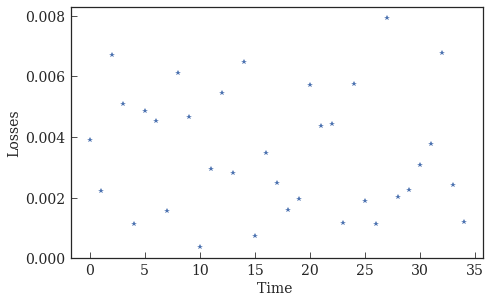

In [68]:
plt.plot(np.linspace(0,len(myDataFrame)-1,len(myDataFrame)),myDataFrame['Losses'],'*')
x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,0,0.05))
plt.xlabel('Time ')
plt.ylabel('Losses')

Text(0.5,1,u'10 shots intensity')

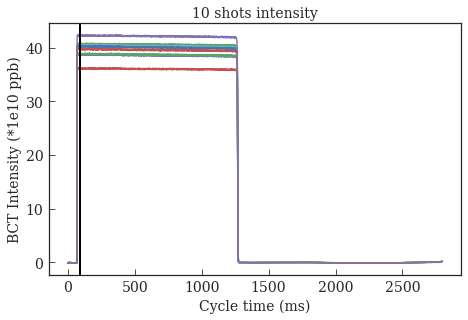

In [69]:
for ll in range(10):
    plt.plot(myDataFrame['Intensity'].values[ll])
    
plt.axvline(x=90, ymin=0, ymax = 8, linewidth=2, color='k')
plt.xlabel('Cycle time (ms)')
plt.ylabel('BCT Intensity (*1e10 ppb)')
plt.title('10 shots intensity')

# Calculate wire scanner emittance
## X plane
### Traditional method

In [70]:
# Wirescanner sigma
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS65_position'] = myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS65_position_idx'] = myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

#instantiate an array object for the result in the frame
myDataFrame['BWS65_data'] = myDataFrame['BWS65_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS65_data'].iloc[r] = np.interp(pos, myDataFrame['BWS65_position'].iloc[r], myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS65_position_idx'].iloc[r]])  
    
#do the fit and get the sigma in mm
myDataFrame['WS_fit_results_x'] = myDataFrame['BWS65_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS_sigma_x'] = myDataFrame['WS_fit_results_x'].apply(lambda x: x[0][-1])


In [71]:
# Emittance calculation
myDataFrame['WS_emittance_x'] = np.nan
myDataFrame['WS_geom_emittance_x'] = np.nan

for n in range(len(myDataFrame)):
#     myDataFrame['WS_emittance_x'].iloc[n] = normalised_emittance('65H',myDataFrame['WS_sigma_x'].values[n],dp=myDataFrame['deltaP_P_rms'].values[n])
    myDataFrame['WS_emittance_x'].iloc[n] = normalised_emittance('65H',myDataFrame['WS_sigma_x'].values[n],dp=0.83e-3)

    myDataFrame['WS_geom_emittance_x'].iloc[n] = myDataFrame['WS_emittance_x'].iloc[n]/(myDataFrame['beta'].iloc[n]*myDataFrame['gamma'].iloc[n])

## Y plane

In [72]:
# Wirescanner sigma
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS85_position'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS85_position_idx'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

#instantiate an array object for the result in the frame
myDataFrame['BWS85_data'] = myDataFrame['BWS85_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS85_data'].iloc[r] = np.interp(pos, myDataFrame['BWS85_position'].iloc[r], myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS85_position_idx'].iloc[r]])  

#do the fit and get the sigma in mm
myDataFrame['WS_fit_results_y'] = myDataFrame['BWS85_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS_sigma_y'] = myDataFrame['WS_fit_results_y'].apply(lambda x: x[0][-1])

In [73]:
# Emittance calculation
myDataFrame['WS_emittance_y'] = myDataFrame['WS_sigma_y'].apply(lambda x: normalised_emittance('85V',x))

myDataFrame['WS_geom_emittance_y'] = np.nan
for n in range(len(myDataFrame)):
    myDataFrame['WS_geom_emittance_y'].iloc[n] = myDataFrame['WS_emittance_y'].iloc[n]/(myDataFrame['beta'].iloc[n]*myDataFrame['gamma'].iloc[n])

# Derive the beam transverse speed

(495, 510)

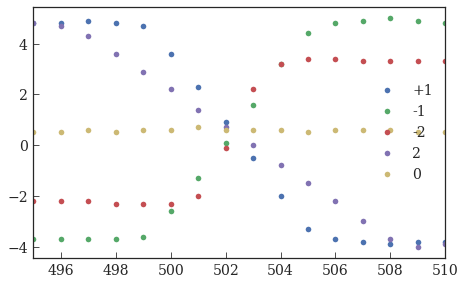

In [84]:
xx = myDataFrame['PR_BPM.AcquisitionMean.value.measStamp'].loc[myDataFrame['Speed_program_m/s']==1].iloc[0]
yy = 0.1*myDataFrame['PR_BPM.AcquisitionMean.value.position'].loc[myDataFrame['Speed_program_m/s']==1].iloc[0][0]

plt.plot(xx,yy,'o',label='+1')

xx = myDataFrame['PR_BPM.AcquisitionMean.value.measStamp'].loc[myDataFrame['Speed_program_m/s']==-1].iloc[0]
yy = 0.1*myDataFrame['PR_BPM.AcquisitionMean.value.position'].loc[myDataFrame['Speed_program_m/s']==-1].iloc[0][0]

plt.plot(xx,yy,'o',label='-1')

xx = myDataFrame['PR_BPM.AcquisitionMean.value.measStamp'].loc[myDataFrame['Speed_program_m/s']==-2].iloc[0]
yy = 0.1*myDataFrame['PR_BPM.AcquisitionMean.value.position'].loc[myDataFrame['Speed_program_m/s']==-2].iloc[0][0]

plt.plot(xx,yy,'o',label='-2')

xx = myDataFrame['PR_BPM.AcquisitionMean.value.measStamp'].loc[myDataFrame['Speed_program_m/s']==2].iloc[0]
yy = 0.1*myDataFrame['PR_BPM.AcquisitionMean.value.position'].loc[myDataFrame['Speed_program_m/s']==2].iloc[0][0]

plt.plot(xx,yy,'o',label='2')

xx = myDataFrame['PR_BPM.AcquisitionMean.value.measStamp'].loc[myDataFrame['Speed_program_m/s']==0].iloc[0]
yy = 0.1*myDataFrame['PR_BPM.AcquisitionMean.value.position'].loc[myDataFrame['Speed_program_m/s']==0].iloc[0][0]

plt.plot(xx,yy,'o',label='0')

plt.legend()


plt.xlim(495,510)

In [91]:
myDataFrame['PA_GSRPOS.Setting.value.amplitudes'].loc[myDataFrame['Speed_program_m/s']==1].iloc[0][0].Y

array([ 0.        ,  0.        ,  3.        , -3.        ,  0.        ,
        0.        , -0.79999999, -0.79999999,  0.        ,  0.        ,
        2.50000003])

(490, 510)

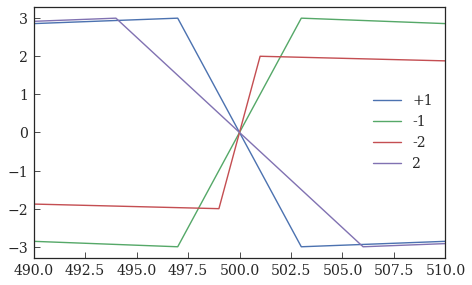

In [99]:
xx = myDataFrame['PA_GSRPOS.Setting.value.amplitudes'].loc[myDataFrame['Speed_program_m/s']==1].iloc[0][0].X
yy = myDataFrame['PA_GSRPOS.Setting.value.amplitudes'].loc[myDataFrame['Speed_program_m/s']==1].iloc[0][0].Y

plt.plot(xx,yy,'-',label='+1')

xx = myDataFrame['PA_GSRPOS.Setting.value.amplitudes'].loc[myDataFrame['Speed_program_m/s']==-1].iloc[0][0].X
yy = myDataFrame['PA_GSRPOS.Setting.value.amplitudes'].loc[myDataFrame['Speed_program_m/s']==-1].iloc[0][0].Y
plt.plot(xx,yy,'-',label='-1')

xx = myDataFrame['PA_GSRPOS.Setting.value.amplitudes'].loc[myDataFrame['Speed_program_m/s']==-2].iloc[0][0].X
yy = myDataFrame['PA_GSRPOS.Setting.value.amplitudes'].loc[myDataFrame['Speed_program_m/s']==-2].iloc[0][0].Y

plt.plot(xx,yy,'-',label='-2')

xx = myDataFrame['PA_GSRPOS.Setting.value.amplitudes'].loc[myDataFrame['Speed_program_m/s']==2].iloc[0][0].X
yy = myDataFrame['PA_GSRPOS.Setting.value.amplitudes'].loc[myDataFrame['Speed_program_m/s']==2].iloc[0][0].Y

plt.plot(xx,yy,'-',label='2')

# xx = myDataFrame['PA_GSRPOS.Setting.value.amplitudes'].loc[myDataFrame['Speed_program_m/s']==0].iloc[0][0].X
# yy = myDataFrame['PA_GSRPOS.Setting.value.amplitudes'].loc[myDataFrame['Speed_program_m/s']==0].iloc[0][0].Y

# plt.plot(xx,yy,'o',label='0')

plt.legend()

plt.xlim(490,510)


## Calculate average emittance per measurement point

In [79]:
ctime_scan = np.linspace(185,305,13)

emix_mean = np.empty(len(ctime_scan),dtype=float)
emiy_mean = np.empty(len(ctime_scan),dtype=float)
emix_std = np.empty(len(ctime_scan),dtype=float)
emiy_std = np.empty(len(ctime_scan),dtype=float)

emix_mean_off = np.empty(len(ctime_scan),dtype=float)
emiy_mean_off = np.empty(len(ctime_scan),dtype=float)
emix_std_off = np.empty(len(ctime_scan),dtype=float)
emiy_std_off = np.empty(len(ctime_scan),dtype=float)


for k, ctime in enumerate(ctime_scan):
    emix_mean[k] = np.mean(myDataFrame['WS_emittance_x'].loc[(myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.acqTimeInCycleSet1']==ctime) & (myDataFrame['RF_on']==True)])
    emiy_mean[k] = np.mean(myDataFrame['WS_emittance_y'].loc[(myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.acqTimeInCycleSet1']==ctime) & (myDataFrame['RF_on']==True)])
    emix_std[k] = np.std(myDataFrame['WS_emittance_x'].loc[(myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.acqTimeInCycleSet1']==ctime) & (myDataFrame['RF_on']==True)])
    emiy_std[k] = np.std(myDataFrame['WS_emittance_x'].loc[(myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.acqTimeInCycleSet1']==ctime) & (myDataFrame['RF_on']==True)])
    emix_mean_off[k] = np.mean(myDataFrame['WS_emittance_x'].loc[(myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.acqTimeInCycleSet1']==ctime) & (myDataFrame['RF_on']==False)])
    emiy_mean_off[k] = np.mean(myDataFrame['WS_emittance_y'].loc[(myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.acqTimeInCycleSet1']==ctime) & (myDataFrame['RF_on']==False)])
    emix_std_off[k] = np.std(myDataFrame['WS_emittance_x'].loc[(myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.acqTimeInCycleSet1']==ctime) & (myDataFrame['RF_on']==False)])
    emiy_std_off[k] = np.std(myDataFrame['WS_emittance_x'].loc[(myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.acqTimeInCycleSet1']==ctime) & (myDataFrame['RF_on']==False)])


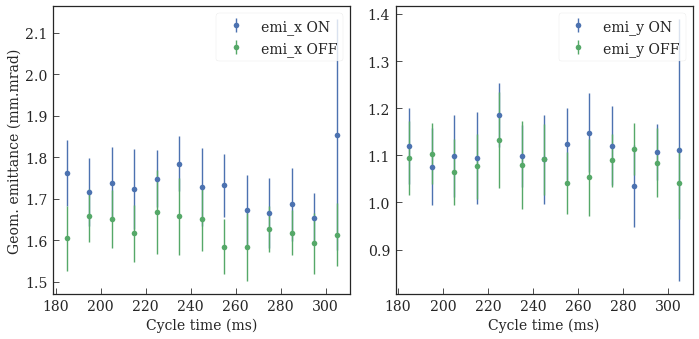

In [81]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].errorbar(ctime_scan, emix_mean, yerr=emix_std, fmt='o',label='emi_x ON')
ax[0].errorbar(ctime_scan, emix_mean_off, yerr=emix_std_off, fmt='o',label='emi_x OFF')

ax[1].errorbar(ctime_scan, emiy_mean, yerr=emiy_std, fmt='o',label='emi_y ON')
ax[1].errorbar(ctime_scan, emiy_mean_off, yerr=emiy_std_off, fmt='o',label='emi_y OFF')


ax[0].set_xlabel('Cycle time (ms)')
ax[0].set_ylabel('Geom. emittance (mm.mrad)')
ax[1].set_xlabel('Cycle time (ms)')

# set axis to get rid of some bad shots
# x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,4,6.2))



ax[0].legend(frameon=True)
ax[1].legend(frameon=True)
fig.tight_layout()

fig.savefig('emix_y_along_cycle_geom.eps', format='eps',dpi=100)

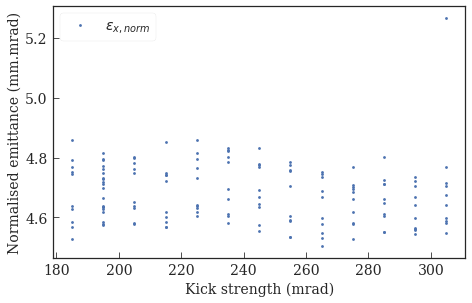

In [43]:
fig, ax = plt.subplots(1)

ax.plot(myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.acqTimeInCycleSet1'],myDataFrame['WS_sigma_x'],'.',label='$\epsilon_{x, norm}$')
plt.xlabel('Kick strength (mrad)')
plt.ylabel('Normalised emittance (mm.mrad)')
# plt.axvline(x=rk, ymin=0, ymax = 8, linewidth=2, color='k')
# set axis to get rid of some bad shots
x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,4,6.2))


# ax.plot(1e3*myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['WS_emittance_y'],'.',label='$\epsilon_{y, norm}$')

plt.legend(frameon=True)

# fig.savefig('BCMS_under_coupling_emi_xy.eps', format='eps')

# Laslett tune shift calculation

In [32]:
myDataFrame['peakLineDensity'] = 0.6

In [33]:
# brightness and intensity
myDataFrame['WS_intensity'] = myDataFrame['Intensity'].apply(lambda x: x[80])
myDataFrame['Brightness'] = myDataFrame['WS_intensity']/(0.5*(myDataFrame['WS_emittance_x']+myDataFrame['WS_emittance_y']))

In [34]:
twiss_file_name = '/eos/user/e/esenes/AnalysisTools/Injection7_optics_Qx_0.21_Qy_0.23_cycled_timefalse.outx'

[deltaQx, deltaQy] = laslett_sc_PS(myDataFrame['peakLineDensity'], myDataFrame['deltaP_P_rms'],
              1e-6*myDataFrame['WS_emittance_x'], 1e-6*myDataFrame['WS_emittance_y'],
              1400, twiss_file_name)

myDataFrame['deltaQx'] = deltaQx
myDataFrame['deltaQy'] = deltaQy

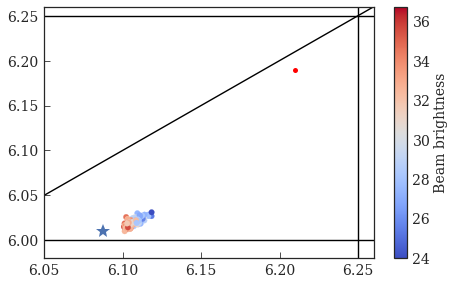

In [35]:
fig, ax = plt.subplots(1)

# working point
Qx = 6.21
Qy = 6.19
plt.plot(Qx,Qy,'r.',markersize=10)

# tune diagram lines
ax.plot([5.8, 6.3],[5.8, 6.3],'k')
ax.plot([6, 6],[5.8, 6.3],'k')
ax.plot([5.8, 6.3],[6, 6],'k')
ax.plot([6.25, 6.25],[5.8, 6.3],'k')
ax.plot([5.8, 6.3],[6.25, 6.25],'k')
# options
plt.xlim([6.05, 6.26])
plt.ylim([5.98, 6.26])
# tune shifts
p1 = ax.scatter(Qx+myDataFrame['deltaQx'], Qy+myDataFrame['deltaQy'], c=myDataFrame['Brightness'], cmap=plt.cm.coolwarm)
clb = fig.colorbar(p1)
clb.set_label('Beam brightness')

# PSB point
[deltaQxPSB, deltaQyPSB] = laslett_sc_PS(0.6, 0.9e-3,
              1e-6*0.984, 1e-6*0.843,
              1400, twiss_file_name)
plt.plot(Qx+deltaQxPSB,Qy+deltaQyPSB,'*',markersize=15)


plt.show()

fig.savefig('BCMS_under_coupling_footprint.eps', format='eps')

## Save the data

In [36]:
myDataFrame.to_pickle('analised_nominal_RF_off.pkl')

In [37]:
np.savetxt('emi_nominal_RFoff.txt',np.array([k_values, emix_mean, emix_std, emiy_mean, emiy_std]).T)